In [143]:
import numpy as np
import matplotlib.pyplot as plt

from astroML.datasets import generate_mu_z
from astroML.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson

from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.model_selection import train_test_split

from astropy import units as u
from astropy import constants
from astropy.cosmology import LambdaCDM, Planck18_arXiv_v2

from scipy.optimize import curve_fit
from scipy.stats import uniform
from scipy.stats import norm

import emcee
import corner

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

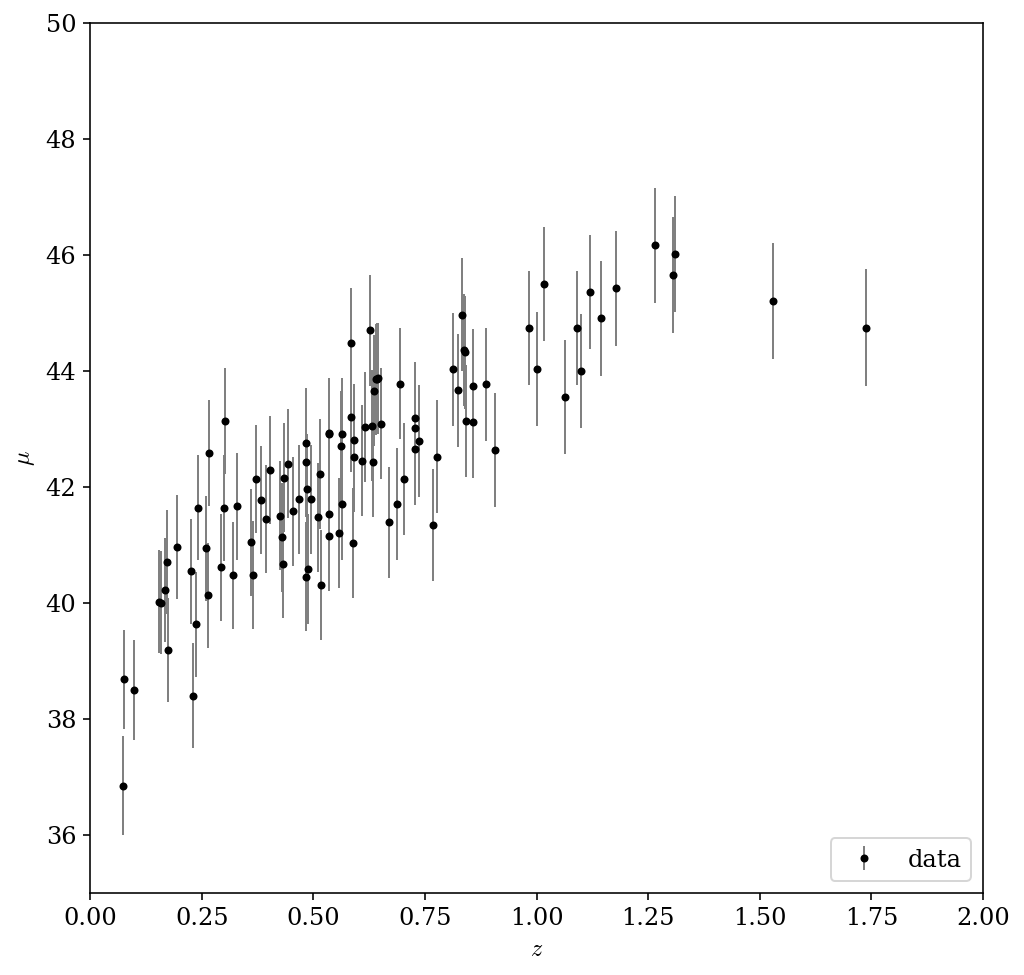

In [144]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

plt.show()

# Regression

In [145]:
z_sk = z_sample[:, np.newaxis] #z in the sklearn format

## Linear regression

In [146]:
linear_model = LinearRegression()
linear_model.fit(z_sk, mu_sample, dmu)

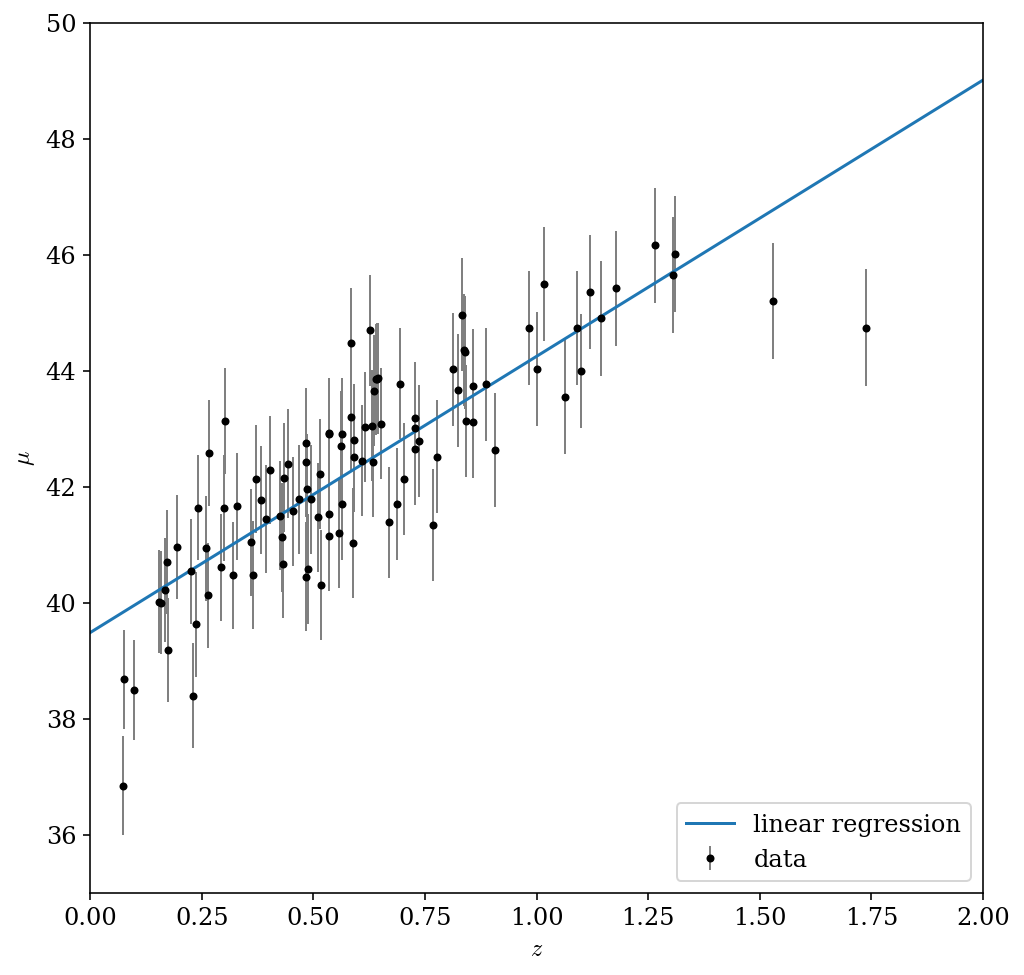

In [147]:
z_grid = np.linspace(0,2,100)[:, None]
mu_linear = linear_model.predict(z_grid)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z_grid, mu_linear,label='linear regression')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

plt.show()

## Polynomial regression

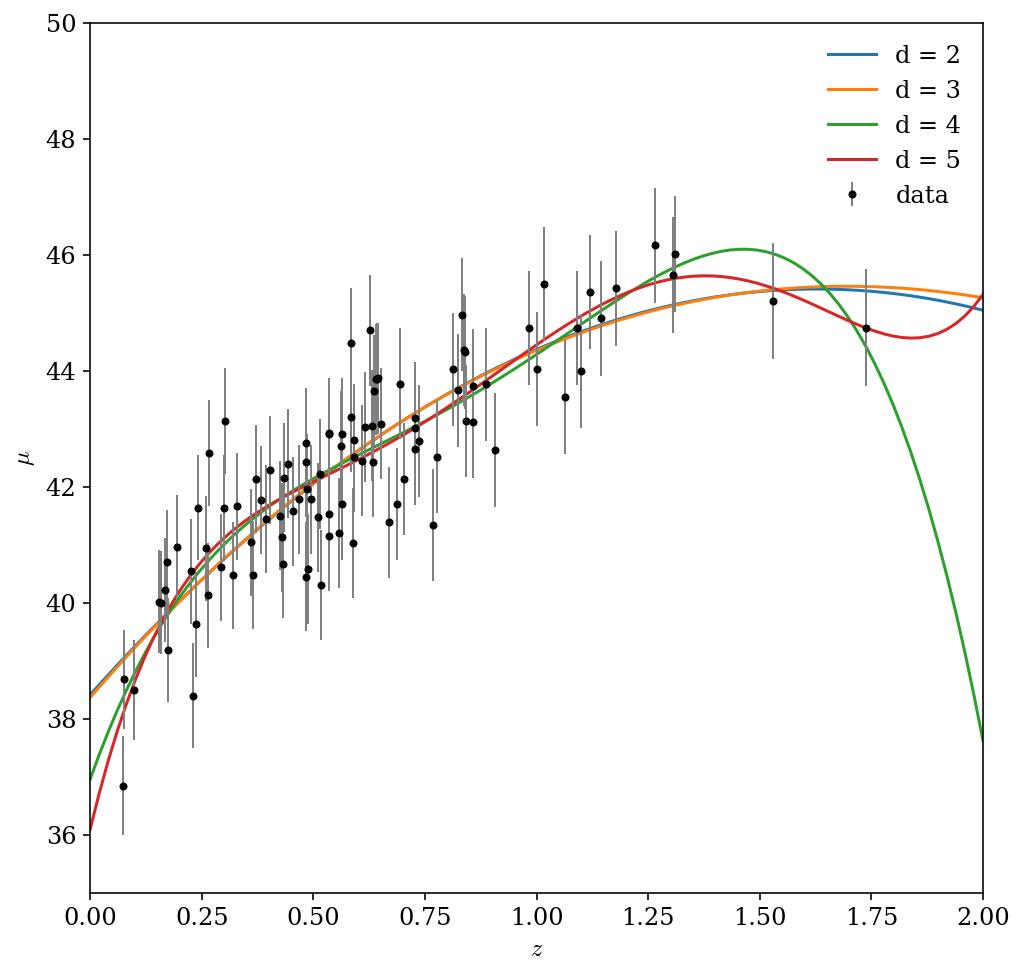

In [148]:
degrees = np.arange(2, 6)

for d in degrees:
    poly_model = PolynomialRegression(d)
    poly_model.fit(z_sk, mu_sample, dmu)
    mu_poly = poly_model.predict(z_grid)
    
    plt.plot(z_grid, mu_poly, label='d = %i' % d)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

d = 1 == underfitting  
d = 2, 3, 4 ?  
d = 5 == overfitting

## Basis function regression

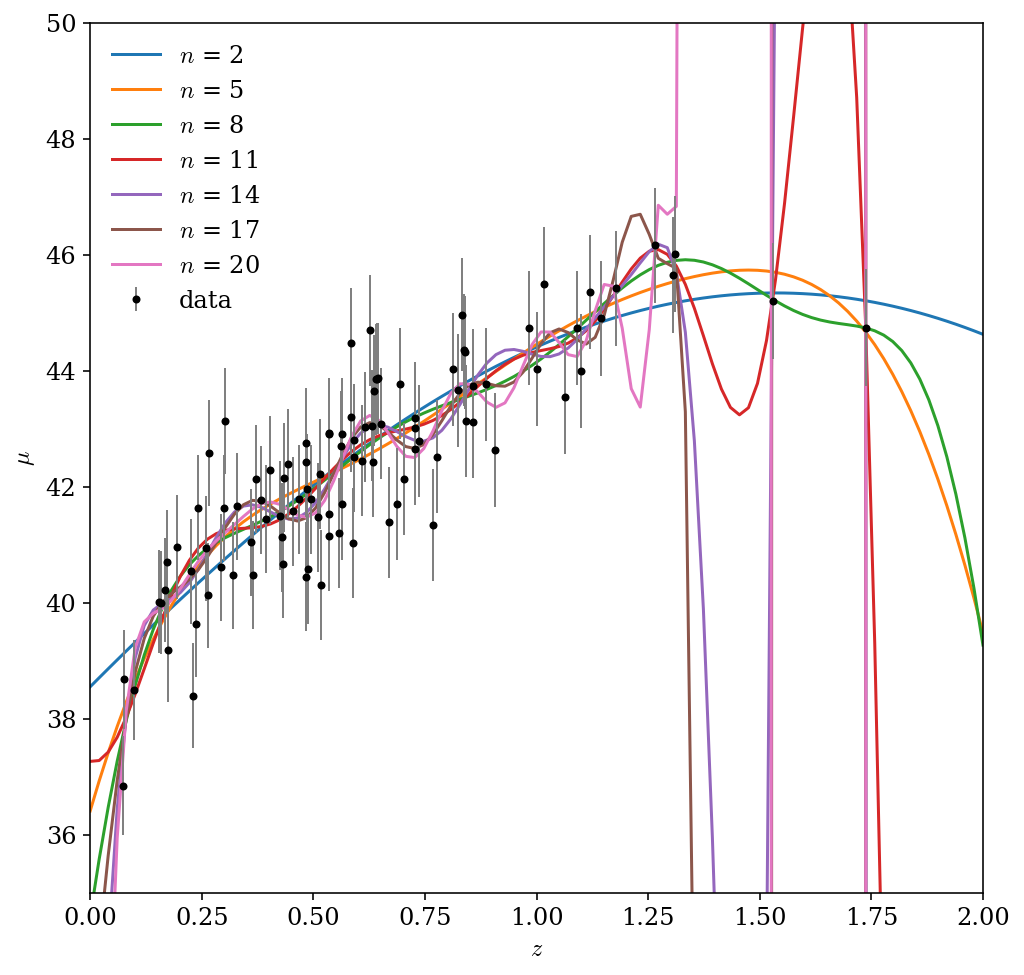

In [149]:
n_try = np.arange(2, 21, 3)
for n in n_try:
    mu_grid = np.linspace(0, 2, n)[:, np.newaxis]
    sigma = mu_grid[1] - mu_grid[0]
    basis_model = BasisFunctionRegression(basis_func='gaussian', mu = mu_grid, sigma = sigma)
    basis_model.fit(z_sk, mu_sample, dmu)
    mu_basis = basis_model.predict(z_grid)
    
    plt.plot(z_grid, mu_basis, label=r'$n$ = %.i' % n)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

# Kernel regression

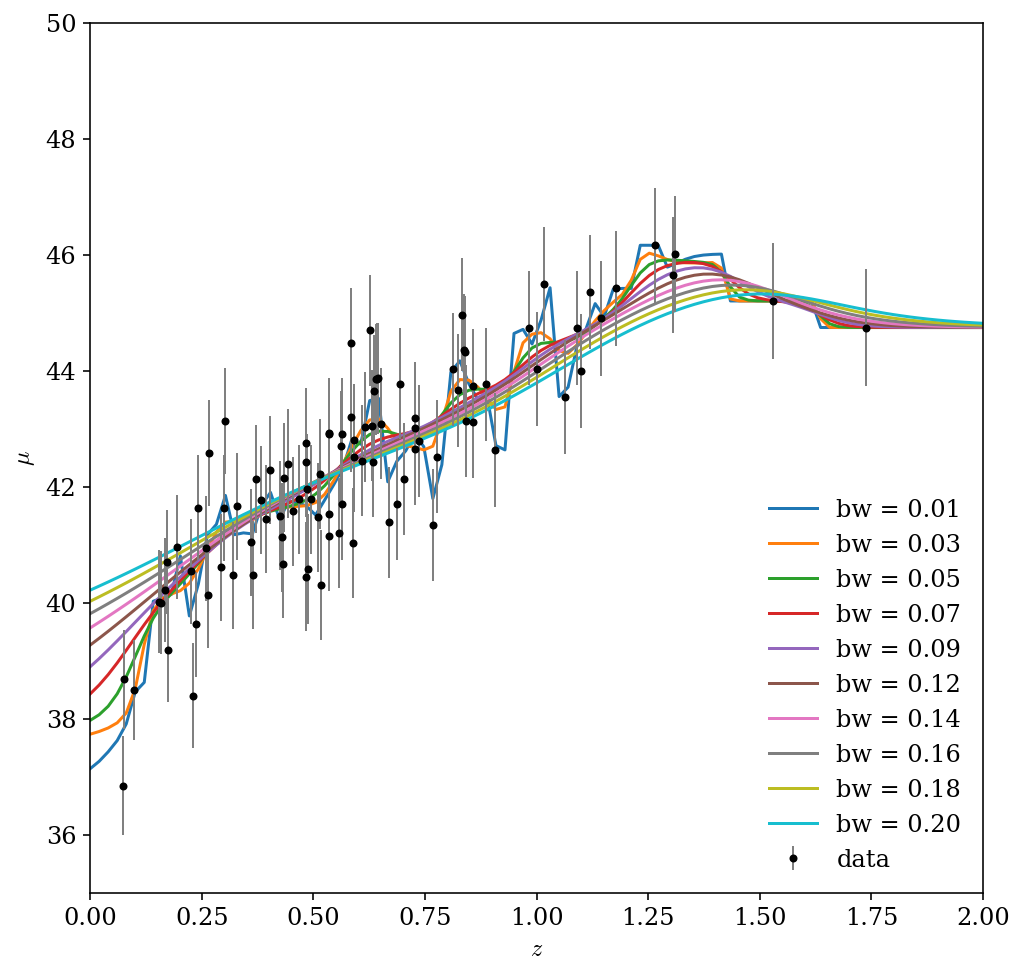

In [150]:
bw_try = np.linspace(0.01, 0.2, 10)
for bw in bw_try:
    
    kernel_model = NadarayaWatson(kernel='gaussian', h=bw)
    kernel_model.fit(z_sk, mu_sample)
    mu_kernel = kernel_model.predict(z_grid)
    
    plt.plot(z_grid, mu_kernel, label= 'bw = %.2f' % bw)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

# Cross validation  
train-cv = 70-30

In [151]:
def error(y, x, model):
    return np.sqrt(np.sum((y - model.predict(x[:, np.newaxis]))**2) / len(x))

In [171]:
#3-fold cross validation 
K = 3
step = int(len(z_sample) / K)
indeces = np.arange(0, len(z_sample))
np.random.shuffle(indeces)
z_random = z_sample[indeces]
mu_random = mu_sample[indeces]
dmu_random = dmu[indeces]

## Polynomial

[7, 2, 3]
best order: 4


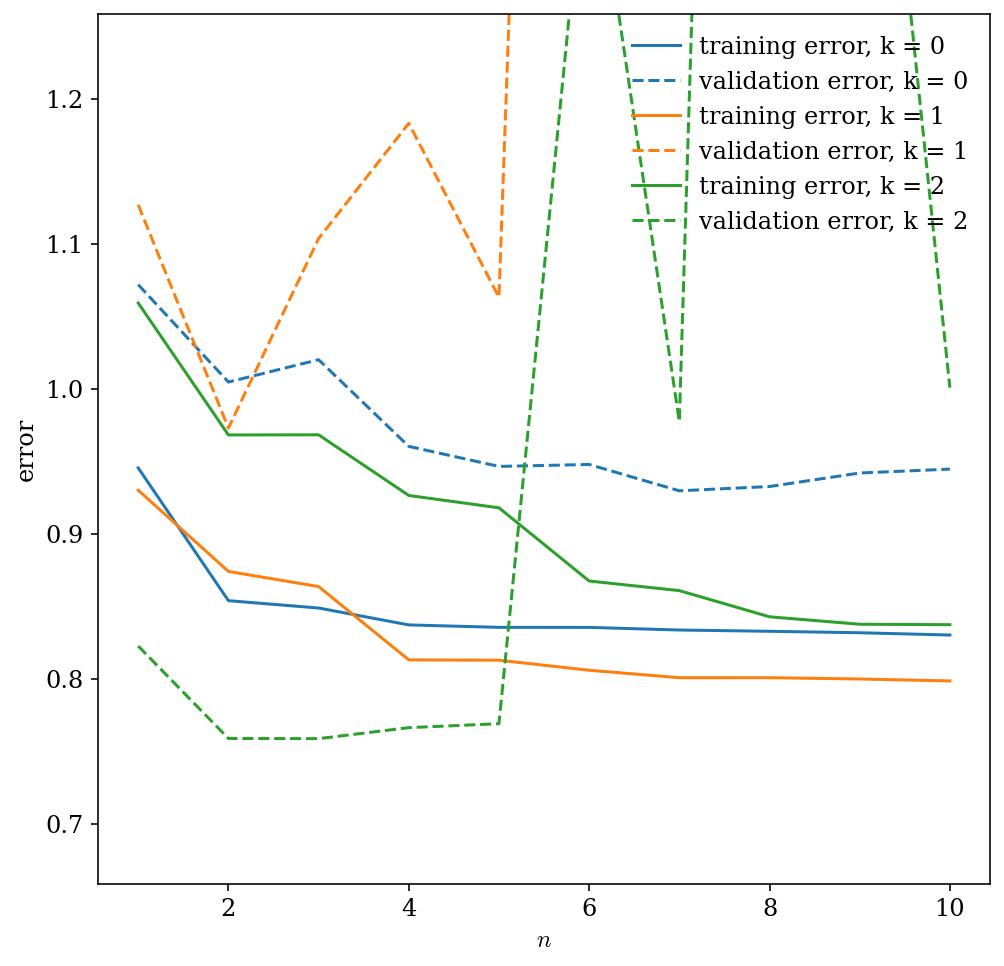

In [172]:
degrees = np.arange(1, 11)
d_list = []

for k in range(K):
    z_val = z_random[k*step:(k+1)*step]
    z_train = np.delete(z_random, np.arange(k*step, (k+1)*step), axis=0)
    
    mu_val = mu_random[k*step:(k+1)*step]
    mu_train = np.delete(mu_random, np.arange(k*step, (k+1)*step), axis=0)
    
    dmu_val = dmu_random[k*step:(k+1)*step]
    dmu_train = np.delete(dmu_random, np.arange(k*step, (k+1)*step), axis=0)
    
    err_train, err_val = [], []
    
    for d in degrees:
        model = PolynomialRegression(d)
        model.fit(z_train[:, np.newaxis], mu_train, dmu_train)
        err_train.append(error(mu_train, z_train, model))
        err_val.append(error(mu_val, z_val, model))
    d_list.append(degrees[np.argmin(err_val)])
    
    color = 'C' + str(k)
    plt.plot(degrees, err_train, c = color, label = 'training error, k = %.i' % k)
    plt.plot(degrees, err_val, ls = '--', c = color, label = 'validation error, k = %.i' % k)
    plt.ylim(min(min(err_train), min(err_val)) - 0.1, min(err_val) + 0.5) #better visualization 

d_best = int(np.mean(d_list))
print(d_list)
print('best order:', d_best)

plt.xlabel(r'$n$')
plt.ylabel('error')

plt.legend(frameon = False)
plt.show()

In [173]:
print('Probably the last two points are in the training set for k = %.i, because n has the largest value (%.i)' % (np.arange(K)[np.argmax(d_list)], max(d_list)))

Probably the last two points are in the training set for k = 0, because n has the largest value (7)


### polynomial regression with the best $d$

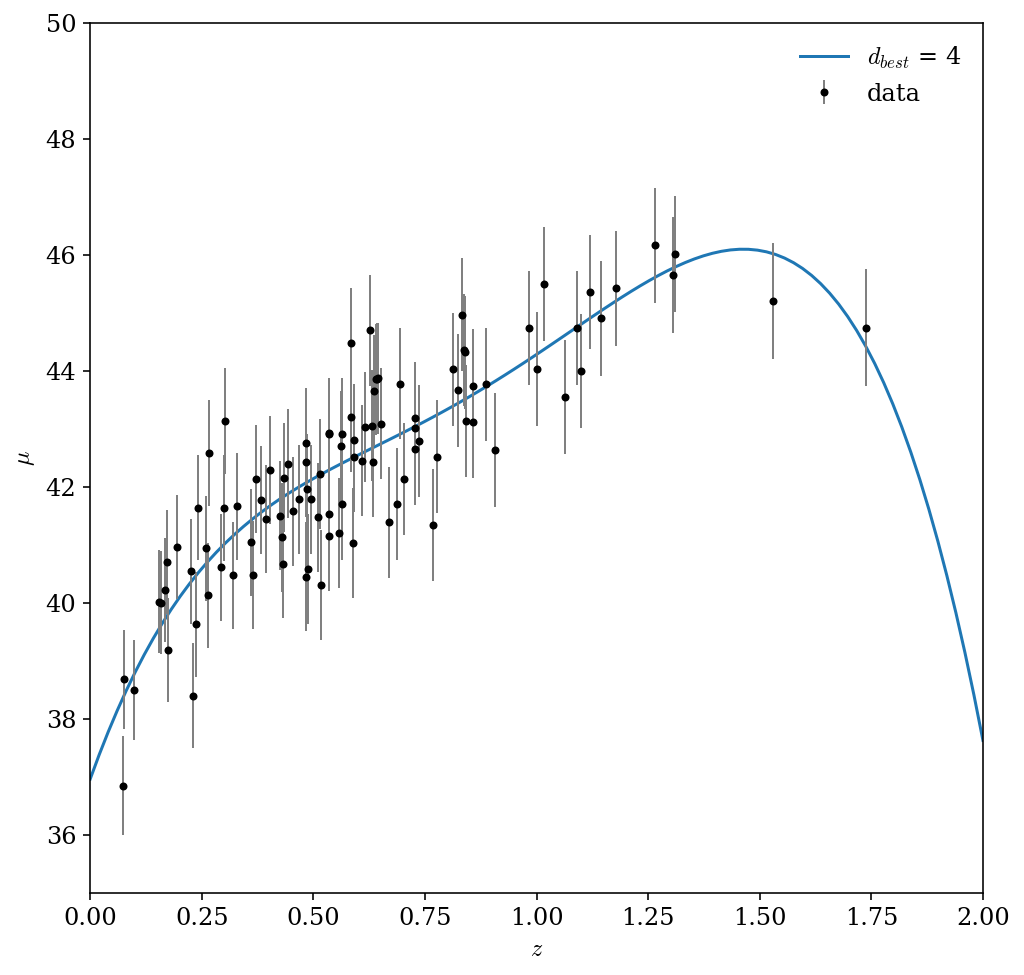

In [174]:
poly_model = PolynomialRegression(d_best)
poly_model.fit(z_sk, mu_sample, dmu)
mu_poly = poly_model.predict(z_grid)
    
plt.plot(z_grid, mu_poly, label=r'$d_{best}$ = %i' % d_best)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

In [175]:
#check if the last points raise the order of the polynomial
N = 30 
degrees = np.arange(1, 11)
d_list_small = []
d_list_big = []

for n in range(N):
    z_train, z_val, mu_train, mu_val, dmu_train, dmu_val = train_test_split(z_sample, mu_sample, dmu, test_size = 0.3, random_state = None)
    err_train, err_val = [], []
    for d in degrees:
        poly_model = PolynomialRegression(d)
        poly_model.fit(z_train[:, np.newaxis], mu_train, dmu_train)
        err_train.append(error(mu_train, z_train, poly_model))
        err_val.append(error(mu_val, z_val, poly_model))
    d_list.append(degrees[np.argmin(err_val)])
    if((z_train > 1.5).any()):
        d_list_big.append(degrees[np.argmin(err_val)])
        print('z > 1.5 in training set -> n = %.i' % degrees[np.argmin(err_val)])
    else:
        d_list_small.append(degrees[np.argmin(err_val)])
d_best = int(np.mean(d_list_small + d_list_big))
print('if neither of the last two points is present in the training set the orders are:', d_list_small)
print('best order:', d_best)

z > 1.5 in training set -> n = 7
z > 1.5 in training set -> n = 2
z > 1.5 in training set -> n = 2
z > 1.5 in training set -> n = 3
z > 1.5 in training set -> n = 4
z > 1.5 in training set -> n = 4
z > 1.5 in training set -> n = 2
z > 1.5 in training set -> n = 7
z > 1.5 in training set -> n = 7
z > 1.5 in training set -> n = 7
z > 1.5 in training set -> n = 4
z > 1.5 in training set -> n = 8
z > 1.5 in training set -> n = 1
z > 1.5 in training set -> n = 4
z > 1.5 in training set -> n = 7
z > 1.5 in training set -> n = 2
z > 1.5 in training set -> n = 2
z > 1.5 in training set -> n = 5
z > 1.5 in training set -> n = 5
z > 1.5 in training set -> n = 5
z > 1.5 in training set -> n = 5
z > 1.5 in training set -> n = 4
z > 1.5 in training set -> n = 5
z > 1.5 in training set -> n = 2
z > 1.5 in training set -> n = 5
if neither of the last two points is present in the training set the orders are: [2, 2, 2, 2, 2]
best order: 3


high $n$ can't be reached without at least one of the last two points in the training set  
the presence of at least one of the last two points in the training set does **not** guarantee a high $n$

## Basis

[7, 2, 3]
the best n is: 4


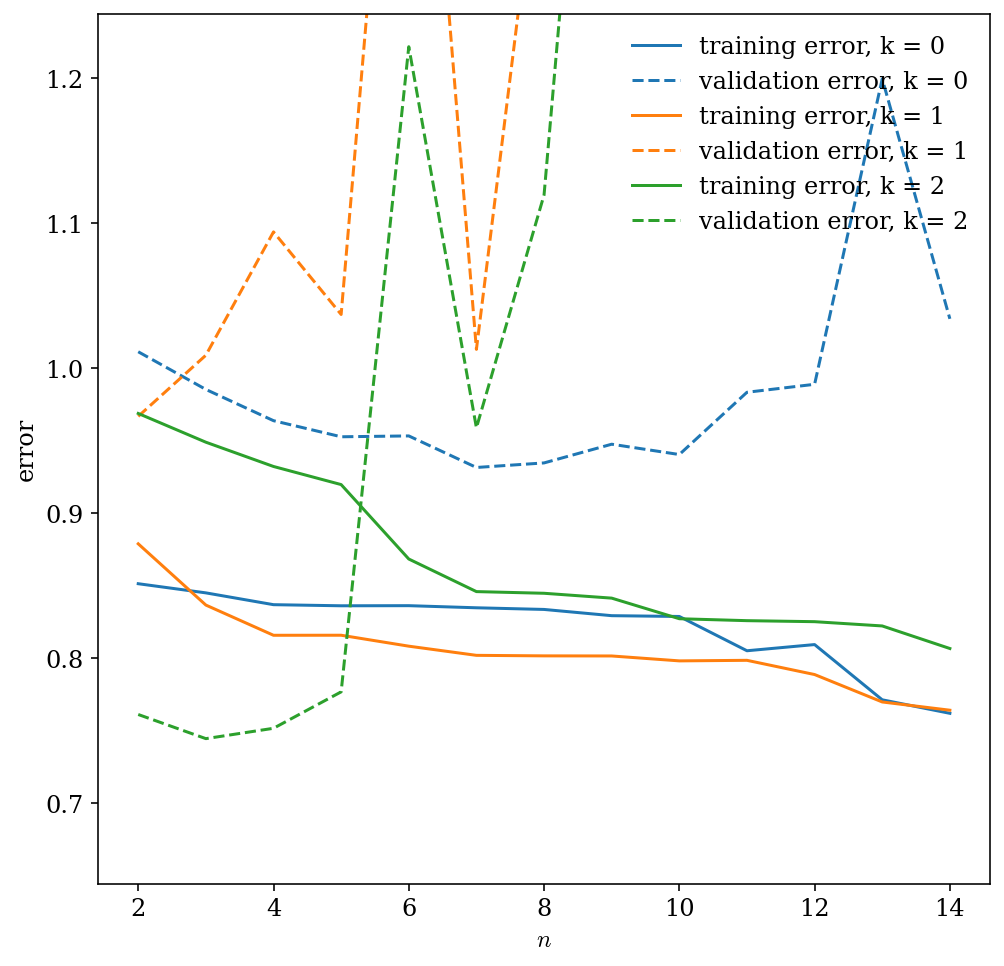

In [176]:
n_try  = np.arange(2, 15)
n_list = []

for k in range(K):
    z_val = z_random[k*step:(k+1)*step]
    z_train = np.delete(z_random, np.arange(k*step, (k+1)*step), axis=0)
    
    mu_val = mu_random[k*step:(k+1)*step]
    mu_train = np.delete(mu_random, np.arange(k*step, (k+1)*step), axis=0)
    
    dmu_val = dmu_random[k*step:(k+1)*step]
    dmu_train = np.delete(dmu_random, np.arange(k*step, (k+1)*step), axis=0)
    
    err_train, err_val = [], []
    
    for n in n_try:
        mu_grid = np.linspace(0, 2, n)[:, np.newaxis]
        sigma = mu_grid[1] - mu_grid[0]
        model = BasisFunctionRegression(basis_func='gaussian', mu = mu_grid, sigma = sigma)
        model.fit(z_train[:, np.newaxis], mu_train, dmu_train)
        err_train.append(error(mu_train, z_train, model))
        err_val.append(error(mu_val, z_val, model))
    n_list.append(n_try[np.argmin(err_val)])
    
    color = 'C' + str(k)
    plt.plot(n_try, err_train, c = color, label = 'training error, k = %.i' % k)
    plt.plot(n_try, err_val, ls = '--', c = color, label = 'validation error, k = %.i' % k)
    plt.ylim(min(min(err_train), min(err_val)) - 0.1, min(err_val) + 0.5) #better visualization 

n_best = int(np.mean(n_list))
print(n_list)
print('the best n is:', n_best)

plt.xlabel(r'$n$')
plt.ylabel('error')

plt.legend(frameon = False)
plt.show()

### basis regression with the best $n$

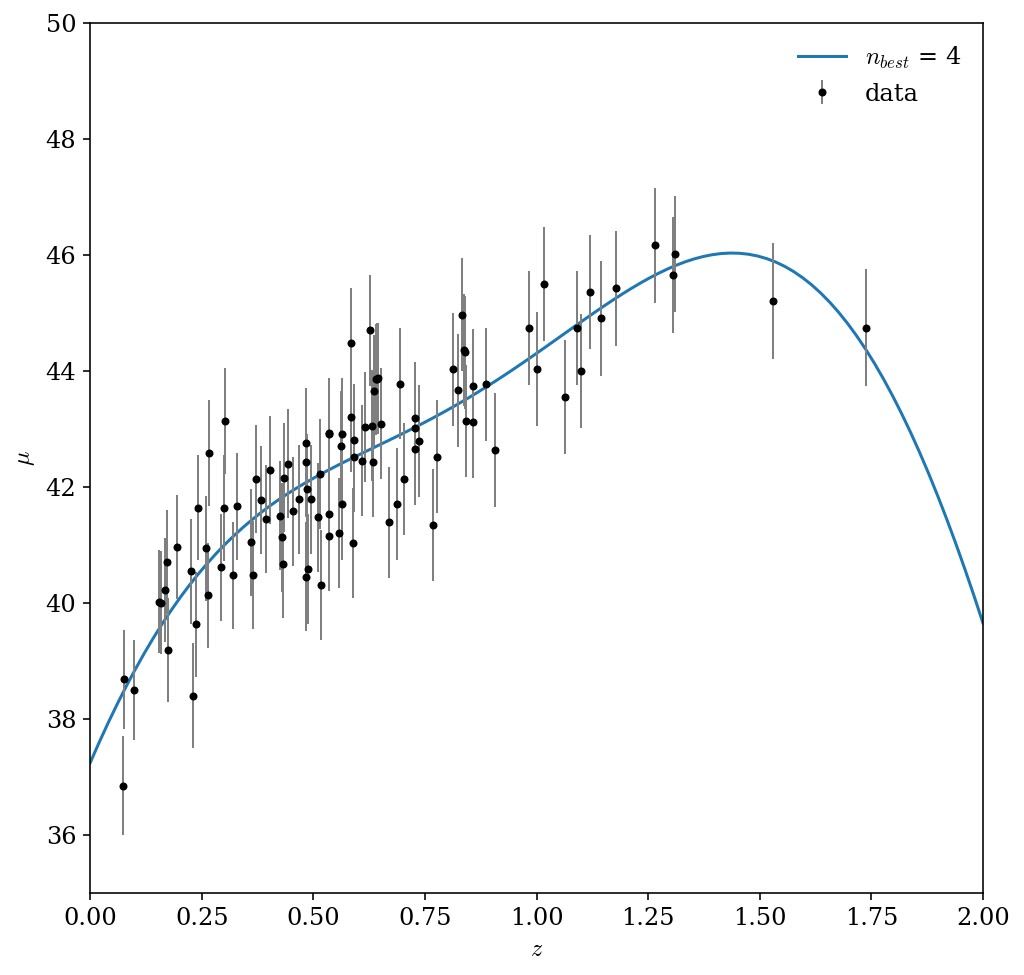

In [177]:
mu_grid = np.linspace(0, 2, n_best)[:, np.newaxis]
sigma = mu_grid[1] - mu_grid[0]
basis_model = BasisFunctionRegression(basis_func='gaussian', mu = mu_grid, sigma = sigma)
basis_model.fit(z_sk, mu_sample, dmu)
mu_basis = basis_model.predict(z_grid)
    
plt.plot(z_grid, mu_basis, label=r'$n_{best}$ = %.i' % n_best)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

## Kernel

[0.03111111111111111, 0.03111111111111111, 0.11555555555555555]
the best bw is: 0.059259259259259255


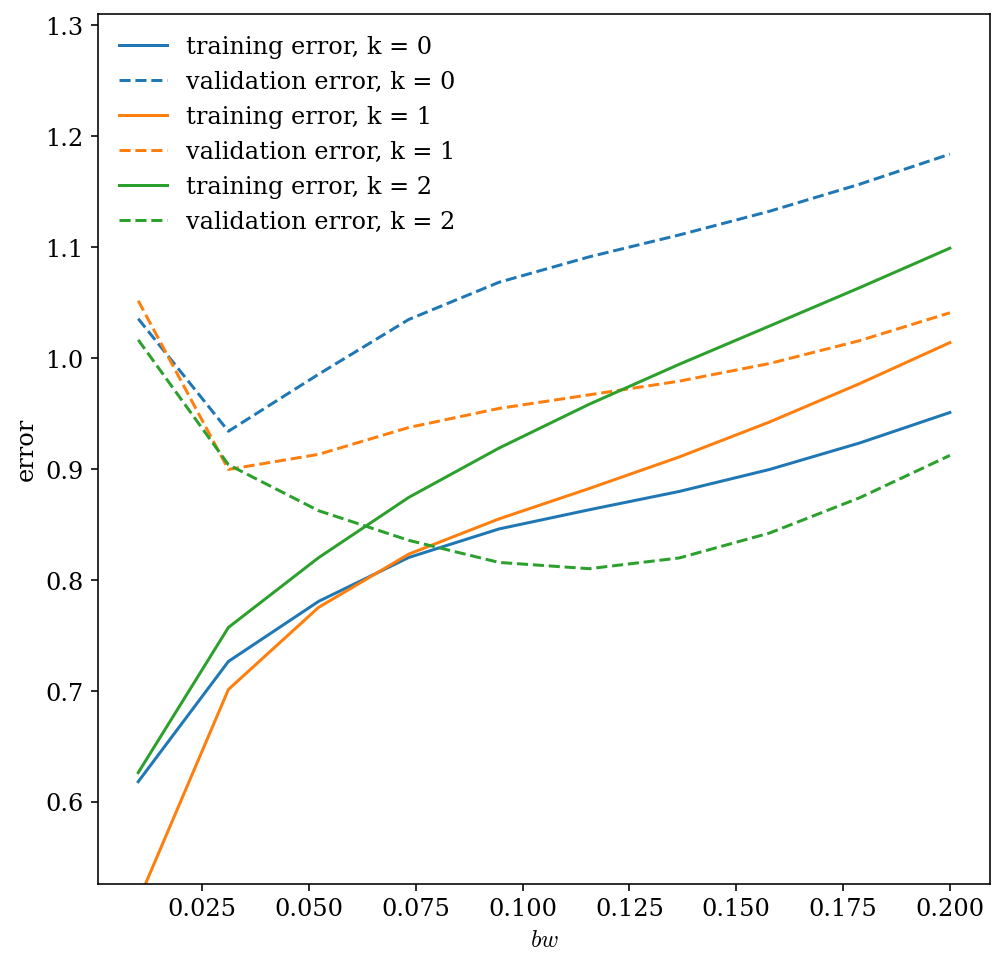

In [178]:
bw_try  = bw_try = np.linspace(0.01, 0.2, 10)
bw_list = []

for k in range(K):
    z_val = z_random[k*step:(k+1)*step]
    z_train = np.delete(z_random, np.arange(k*step, (k+1)*step), axis=0)
    
    mu_val = mu_random[k*step:(k+1)*step]
    mu_train = np.delete(mu_random, np.arange(k*step, (k+1)*step), axis=0)
    
    dmu_val = dmu_random[k*step:(k+1)*step]
    dmu_train = np.delete(dmu_random, np.arange(k*step, (k+1)*step), axis=0)
    
    err_train, err_val = [], []
    
    for bw in bw_try:
        model = NadarayaWatson(kernel='gaussian', h=bw)
        model.fit(z_train[:, np.newaxis], mu_train)
        err_train.append(error(mu_train, z_train, model))
        err_val.append(error(mu_val, z_val, model))
    bw_list.append(bw_try[np.argmin(err_val)])
    
    color = 'C' + str(k)
    plt.plot(bw_try, err_train, c = color, label = 'training error, k = %.i' % k)
    plt.plot(bw_try, err_val, ls = '--', c = color, label = 'validation error, k = %.i' % k)
    plt.ylim(min(min(err_train), min(err_val)) - 0.1, min(err_val) + 0.5) #better visualization 

bw_best = np.mean(bw_list)
print(bw_list)
print('the best bw is:', bw_best)

plt.xlabel(r'$bw$')
plt.ylabel('error')

plt.legend(frameon = False)
plt.show()

### kernel regression with the best bandwidth

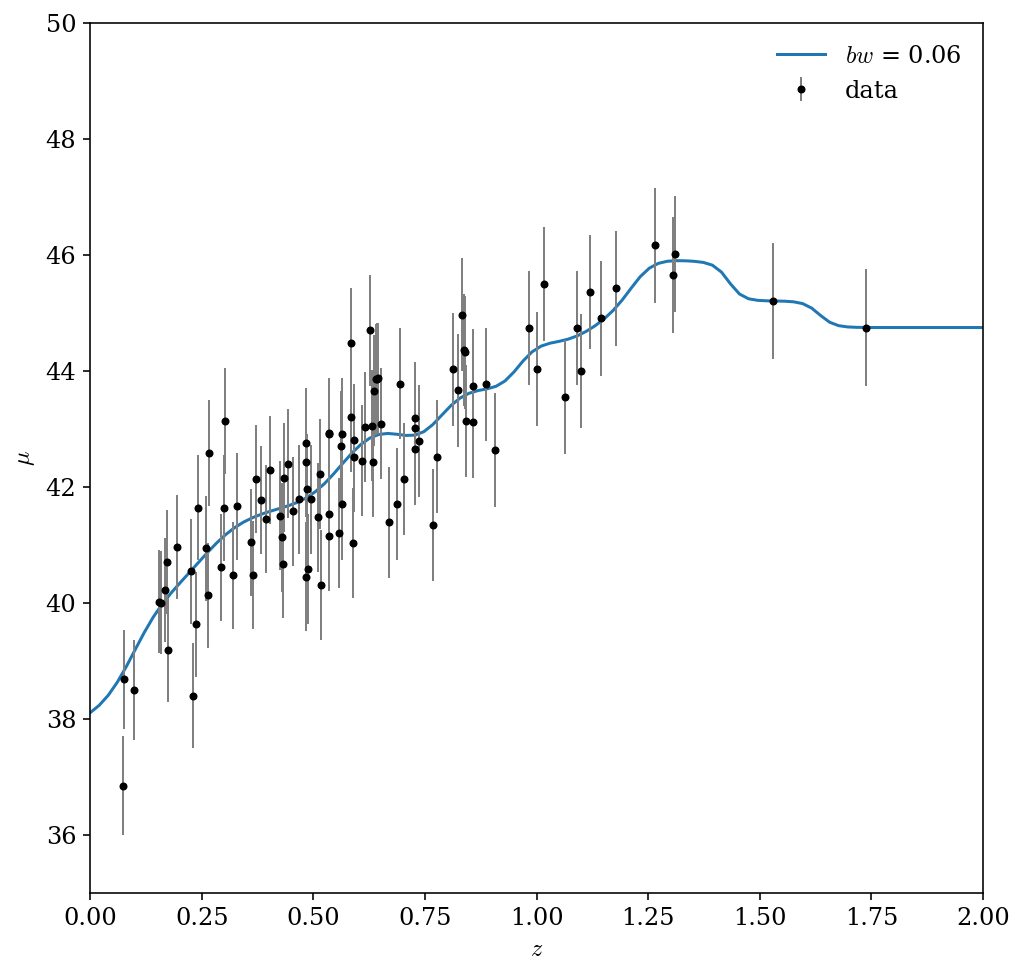

In [179]:
kernel_model = NadarayaWatson(kernel='gaussian', h=bw_best)
kernel_model.fit(z_sk, mu_sample)
mu_kernel = kernel_model.predict(z_grid)
    
plt.plot(z_grid, mu_kernel, label=r'$bw$ = %.2f' % bw_best)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

# PART 2

## GPR

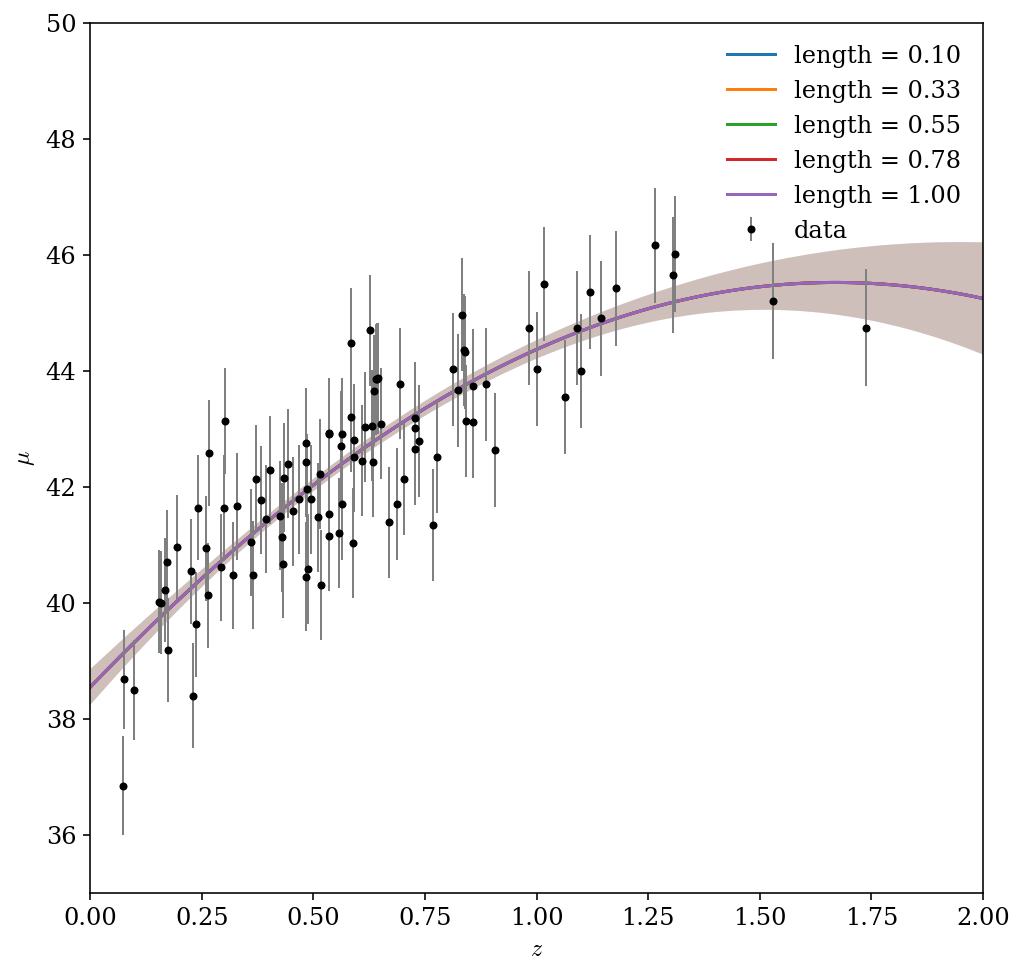

In [30]:
length_scales = np.linspace(0.1, 1, 5)
for length_scale in length_scales:
    kernel = kernels.ConstantKernel(1.0) * kernels.RBF(length_scale)
    gpr = GaussianProcessRegressor(kernel = kernel, alpha = dmu**2)
    gpr.fit(z_sk, mu_sample)
    mu_gpr, mu_sigma = gpr.predict(z_grid, return_std=True)
    
    plt.plot(z_grid, mu_gpr, label= 'length = %.2f' % length_scale)
    plt.fill_between(z_grid[:,0], mu_gpr - mu_sigma, mu_gpr + mu_sigma, alpha = 0.1)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

implement the cross validation

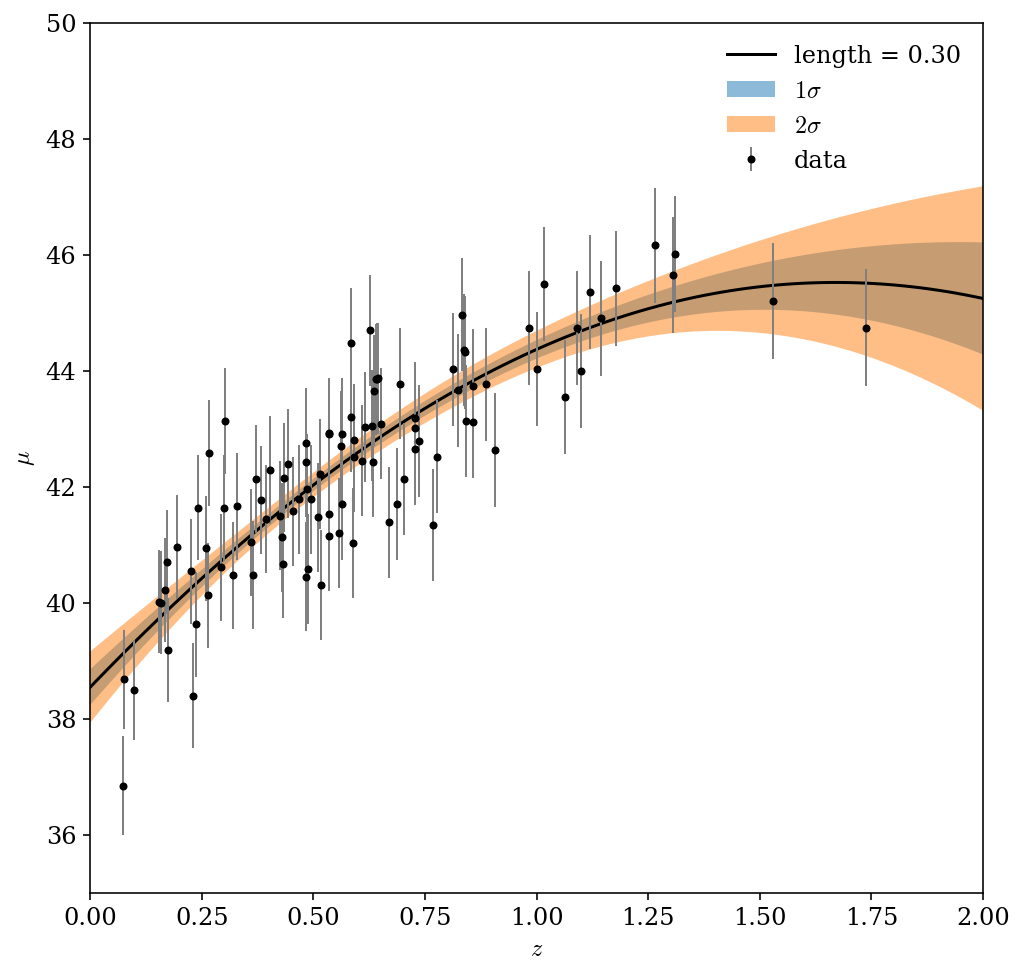

In [22]:
length_scale = 0.3
kernel = kernels.ConstantKernel(1.0) * kernels.RBF(length_scale)
gpr = GaussianProcessRegressor(kernel = kernel, alpha = dmu**2)
gpr.fit(z_sk, mu_sample)
mu_gpr, mu_sigma = gpr.predict(z_grid, return_std=True)
    
plt.plot(z_grid, mu_gpr, c = 'k', label = 'length = %.2f' % length_scale)
plt.fill_between(z_grid[:,0], mu_gpr - mu_sigma, mu_gpr + mu_sigma, alpha = 0.5, label = r'$1\sigma$')
plt.fill_between(z_grid[:,0], mu_gpr - 2*mu_sigma, mu_gpr + 2*mu_sigma, alpha = 0.5, label = r'$2\sigma$')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

# $\Lambda$CDM model

$\mu = 5\log(\frac{c / H_0}{10\,pc} (1+z) \int_0^z \frac{1}{\sqrt{\Omega_M (1+z)^3 + \Omega_\Lambda}})$  

NB: in order to try both the bayesian methods, use a MCMC here and a nested sampling later

In [19]:
def model(z, H0 ,Om):
    cosmology = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmology.distmod(z).value

In [20]:
def loglikelihood(theta):
    H0, Om = theta
    if Om > 0:
        mu_model = model(z_sample, H0, Om)
        return np.sum(norm(loc=mu_model, scale=dmu).logpdf(mu_sample))
    if Om < 0:
        return -np.inf

In [21]:
def logprior(theta):
    H0, Om = theta
    if 50 < H0 < 100 and 0 < Om < 1:
        return 0
    else:
        return -np.inf

In [22]:
def logposterior(theta):
    return loglikelihood(theta) + logprior(theta)

In [23]:
ndim = 2
nwalkers = 20
nsteps = int(1e4)

#initial guess
theta_guess = np.array([60, 0.4]) + np.random.rand(nwalkers, ndim) 

In [24]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior)
sampler.run_mcmc(theta_guess, nsteps)

print('---')

/Users/alessandrosantini/.pyenv/versions/3.8.12/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


State([[63.81283368  0.42044838]
 [60.14352212  0.81313442]
 [64.54070327  0.57986982]
 [65.97335881  0.41512701]
 [69.07585474  0.51516785]
 [61.57218555  0.70966203]
 [67.73577933  0.34821119]
 [61.02136158  0.91791721]
 [69.89922539  0.41909881]
 [61.03014335  0.71282519]
 [70.18165308  0.12674358]
 [70.70011202  0.19196478]
 [73.49453944  0.29551997]
 [58.50985373  0.90748227]
 [74.92140002  0.25279817]
 [72.0175678   0.238687  ]
 [66.81037992  0.25249617]
 [68.23685692  0.37742649]
 [61.32911722  0.88049757]
 [63.82332162  0.40228238]], log_prob=[-133.3797145  -133.26335859 -133.0158048  -132.88238753 -133.95071913
 -133.12234856 -132.84148153 -133.83845765 -133.37037018 -133.13988487
 -134.33181969 -133.1716657  -133.5374903  -133.40015031 -133.64171897
 -132.89487527 -133.80845811 -132.83099418 -133.72012235 -133.51961387], blobs=None, random_state=('MT19937', array([2611624951, 1347334978, 3133542070, 2138537260, 3287660508,
       3681880045,  283623061,  870564731, 1200334858

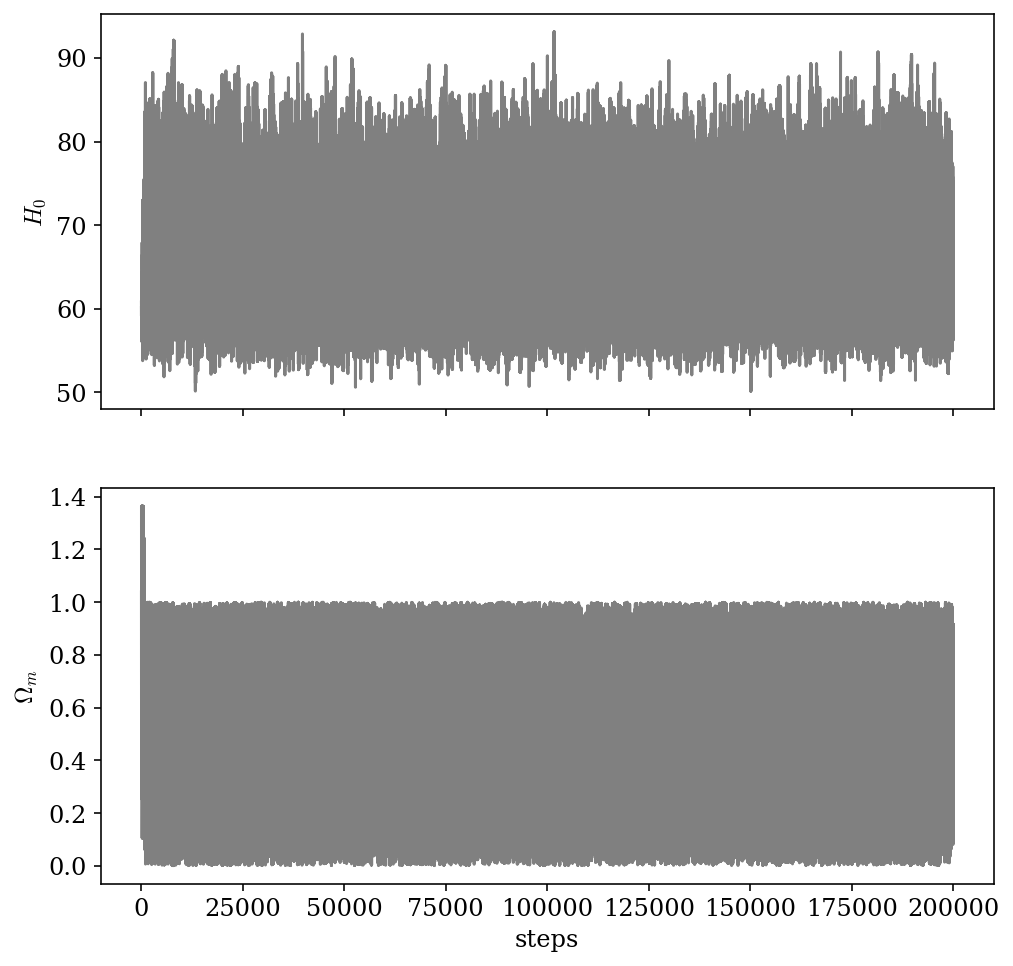

In [25]:
#chains
samples = sampler.get_chain(flat = True)

fig, axes = plt.subplots(ndim, sharex = True)
label = ['$H_0$', '$\Omega_m$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], c = 'gray')
    ax.set_ylabel(label[i])
plt.xlabel('steps') 
plt.show()

In [26]:
#burn and thin the chain
corr_time = sampler.get_autocorr_time()
final_samples = sampler.get_chain(thin = int(max(corr_time)), discard = 4 * int(max(corr_time)), flat = True)

In [27]:
Planck18_arXiv_v2.H0

<Quantity 67.66 km / (Mpc s)>

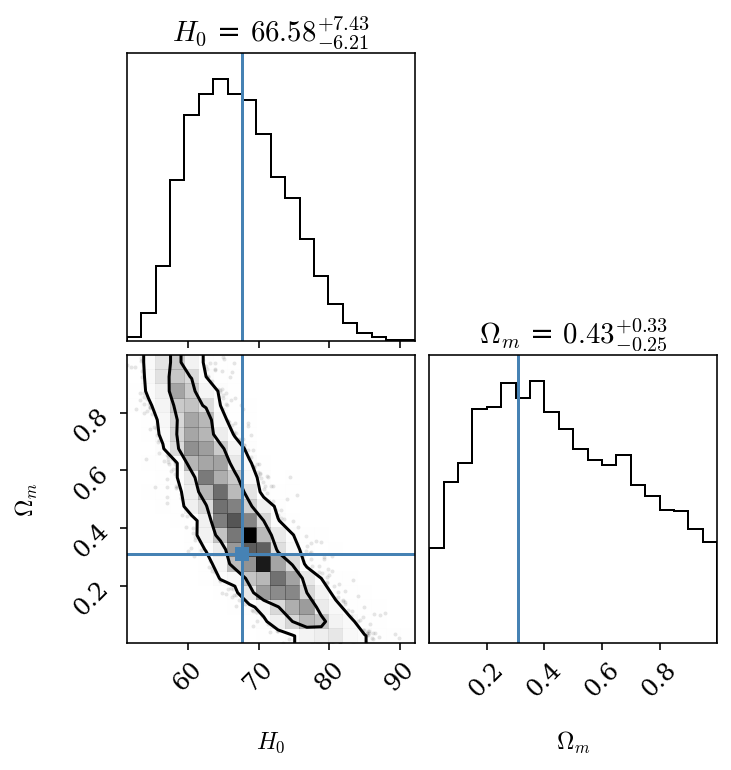

In [28]:
#corner plot
planck = Planck18_arXiv_v2
true_vals = [planck.H0.value, planck.Om0]
fig = corner.corner(
    final_samples, labels=label, levels=[0.68,0.95], show_titles=True, truths=true_vals
);

$H_0$ and $\Omega_m$ seems to be correlated, there is a preferential direction in the $H_0 - \Omega_m$ plane.

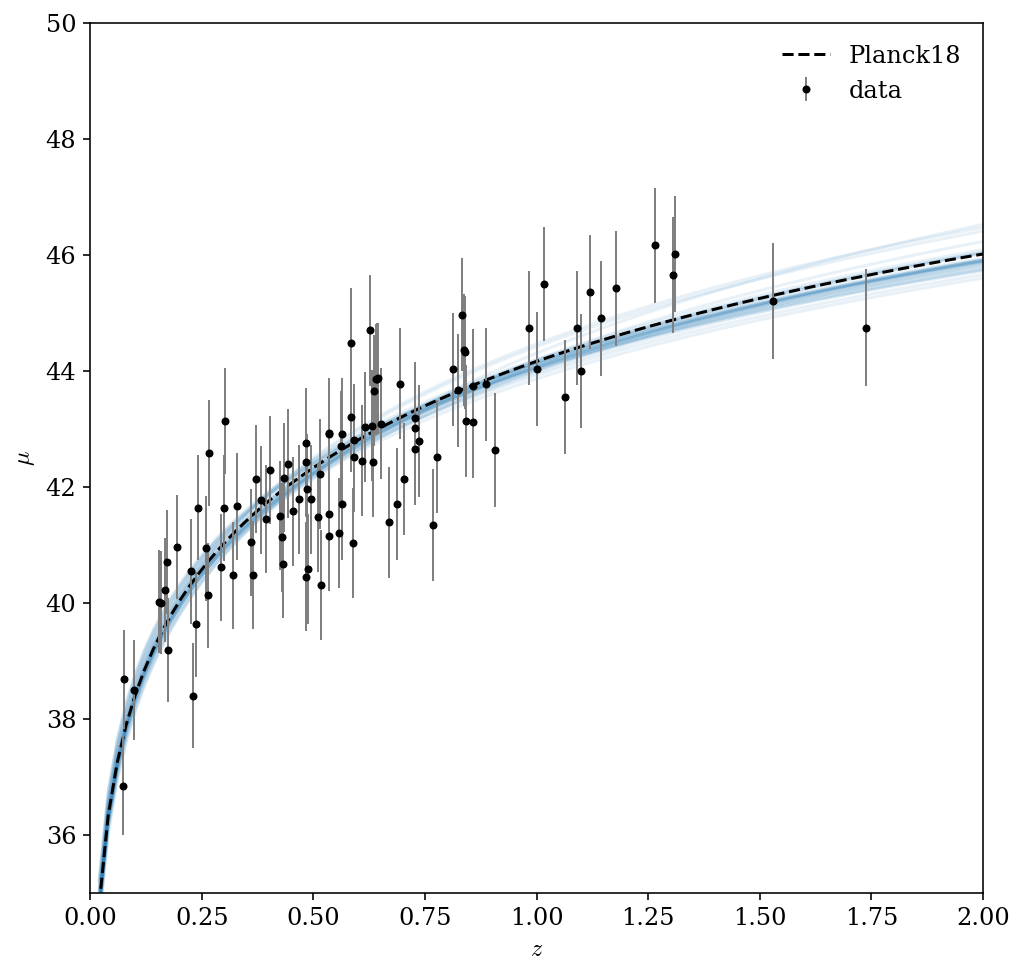

In [34]:
# 30 random samples to plot
N_rand = 30
mask = np.random.choice(len(final_samples), size = N_rand)
choices = final_samples[mask]

for H, Om in choices:
    plt.plot(z_grid[1:], model(z_grid[1:], H, Om), c = 'C0', alpha = 0.1)

plt.plot(z_grid[1:], model(z_grid[1:], *true_vals), c = 'k', ls = '--', label = 'Planck18')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

## model without dark energy: $\Omega_m=1$

**using a nested sampling for this**

In [56]:
def loglikelihood_dm(theta):
    H0 = float(theta)
    Om = 1
    mu_model = model(z_sample, H0, Om)
    return np.sum(norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

In [57]:
def prior(u):
    min_H = 40
    max_H = 100
    return min_H + u*(max_H - min_H)

In [67]:
ndim = 1
sampler = dynesty.NestedSampler(loglikelihood_dm, prior, ndim, nlive=1000)
sampler.run_nested()
results = sampler.results

2628it [00:48, 54.28it/s, +1000 | bound: 0 | nc: 1 | ncall: 13940 | eff(%): 26.026 | loglstar:   -inf < -133.530 <    inf | logz: -135.779 +/-    nan | dlogz:  0.001 >  1.009]


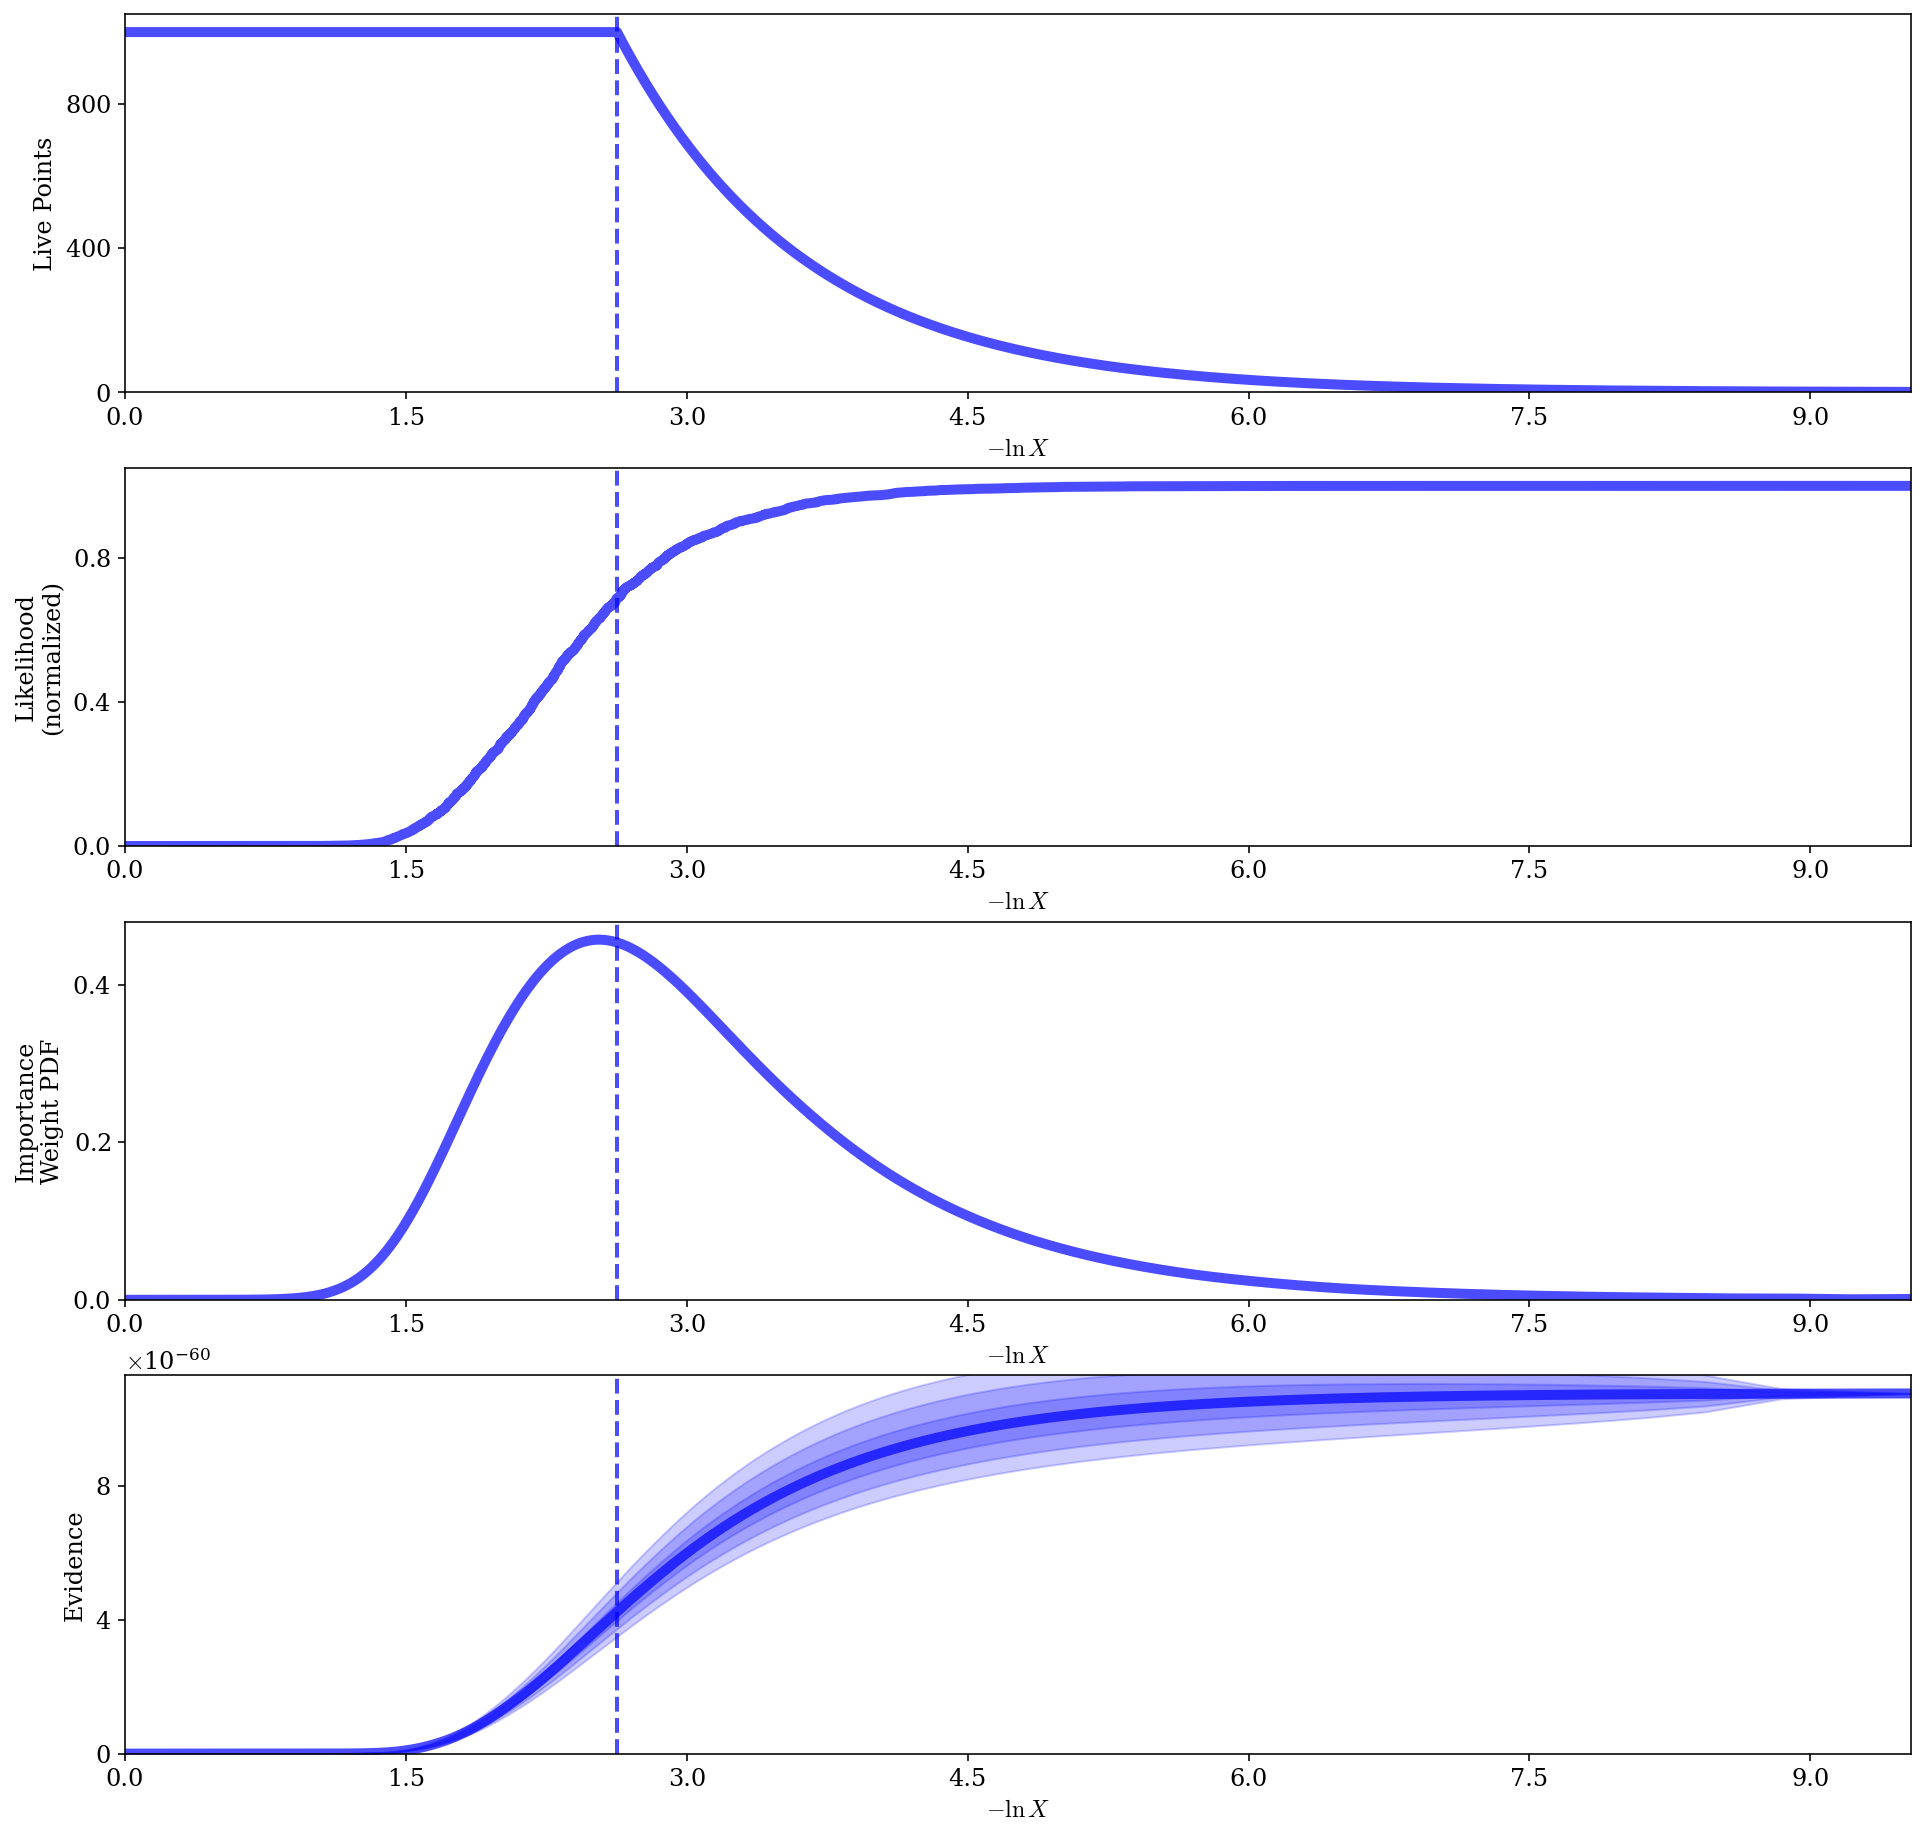

In [68]:
rfig, raxes = dyplot.runplot(results)

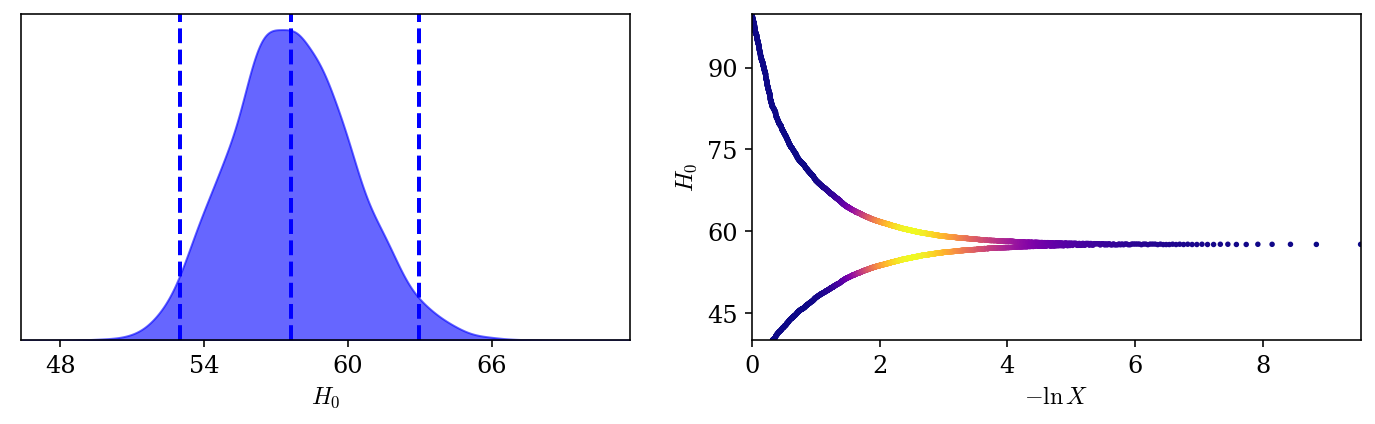

In [81]:
tfig, taxes = dyplot.traceplot(results, labels=['$H_0$'])

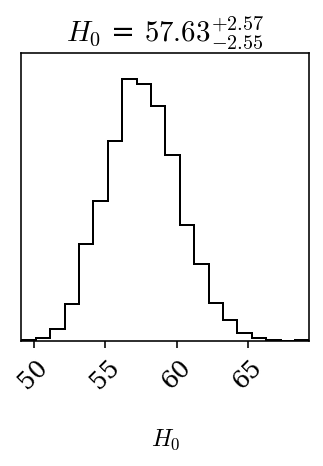

In [87]:
samples = results.samples  # samples
weights = np.exp(results.logwt - results.logz[-1])  # normalized weights

samples_equal = dyfunc.resample_equal(samples, weights)
labels = [r'$H_0$']

corner.corner(samples_equal, labels=labels, show_titles=True);

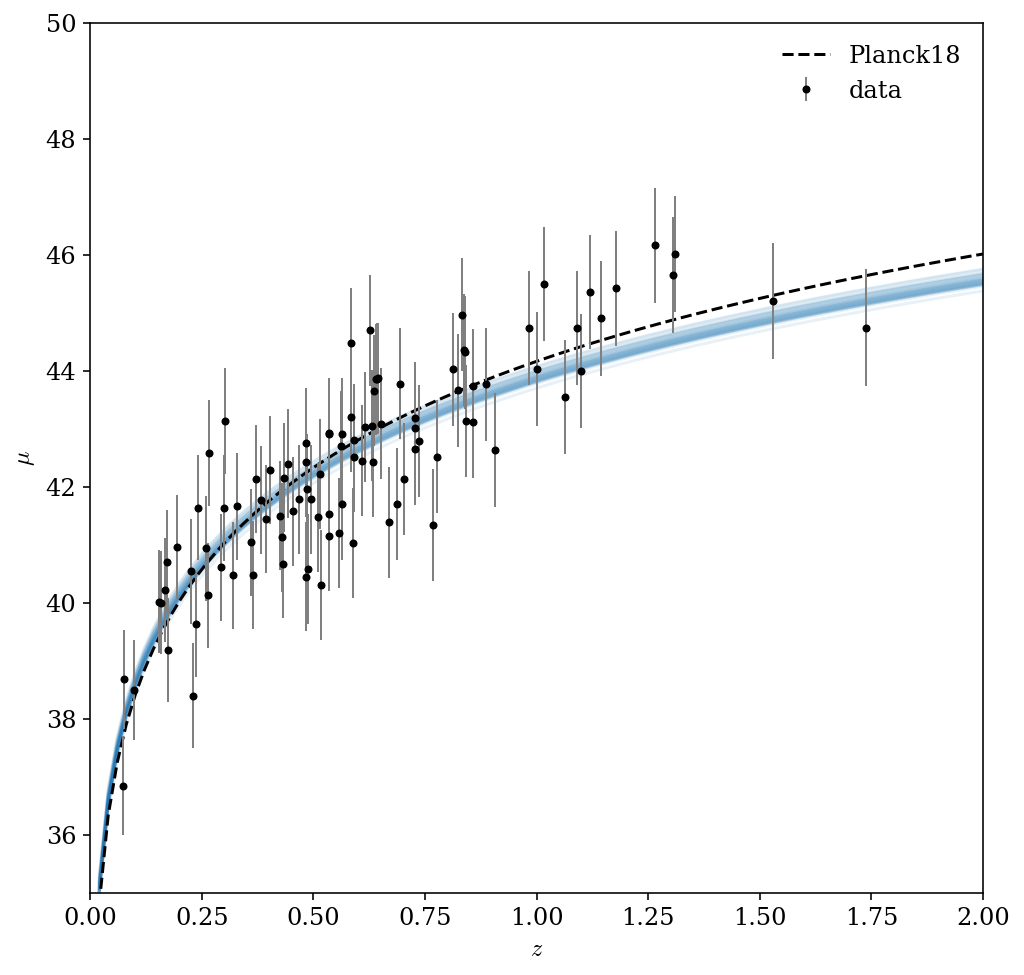

In [96]:
# 30 random samples to plot
N_rand = 30
mask = np.random.choice(len(samples_equal), size = N_rand)
choices = samples_equal[mask][:, 0]
Om = 1

for H in choices:
    plt.plot(z_grid[1:], model(z_grid[1:], H, Om), c = 'C0', alpha = 0.1)

plt.plot(z_grid[1:], model(z_grid[1:], *true_vals), c = 'k', ls = '--', label = 'Planck18')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

not too different: these data could be explained also by a model without dark matter and $H_0 \simeq 57 km s^{-1} Mpc^{-1}$